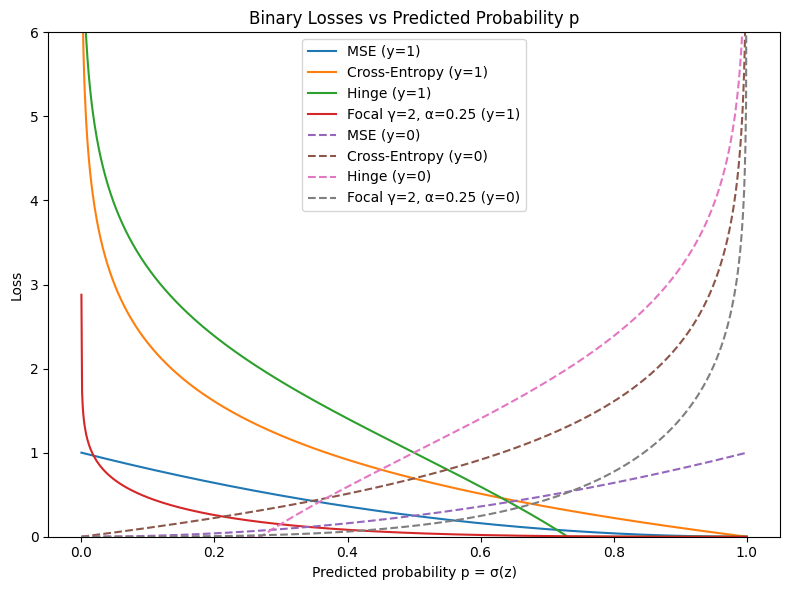

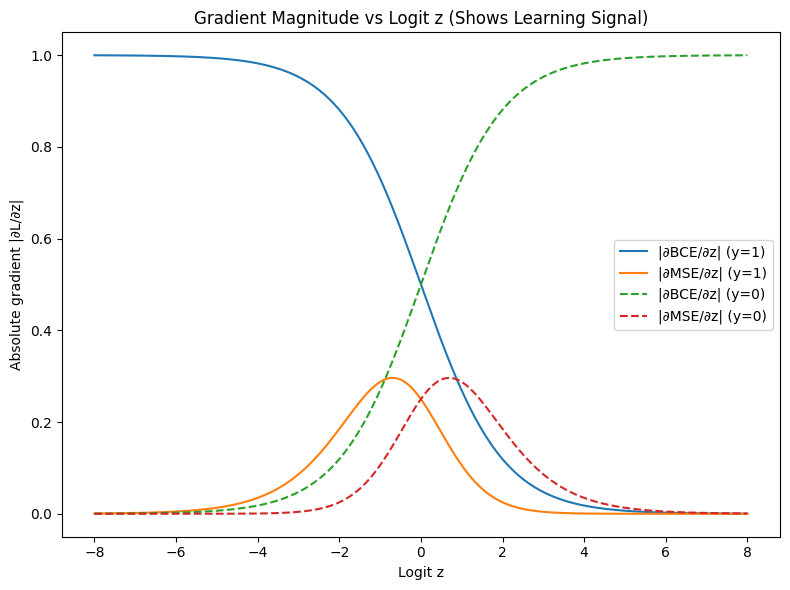

In [40]:


import numpy as np
import matplotlib.pyplot as plt
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logit(p):
    p = np.clip(p, 1e-8, 1-1e-8)
    return np.log(p/(1-p))

def mse_loss(p, y):
    return (p - y)**2

def bce_loss(p, y):
    p = np.clip(p, 1e-12, 1-1e-12)
    return -(y*np.log(p) + (1-y)*np.log(1-p))

def hinge_loss_from_p(p, y):
    """
    Hinge is defined on margins with targets t in {-1,+1} and score z.
    We map probability -> logit for visualization.
    """
    z = logit(p)        # margin proxy
    t = 2*y - 1         # {0,1} -> {-1,+1}
    return np.maximum(0.0, 1 - t*z)

def focal_loss(p, y, gamma=2.0, alpha=0.25):
    p = np.clip(p, 1e-12, 1-1e-12)
    if y == 1:
        return -alpha * (1-p)**gamma * np.log(p)
    else:
        return -(1-alpha) * p**gamma * np.log(1-p)

# ---------- Gradients wrt logit z (training dynamics) ----------
def grad_bce_wrt_z(z, y):
    p = sigmoid(z)
    return (p - y)  # BCE-with-logits: ∂L/∂z = σ(z) - y

def grad_mse_wrt_z(z, y):
    p = sigmoid(z)
    return 2*(p - y) * p*(1-p)  # chain rule through sigmoid

# ==================== PLOT 1: Loss vs predicted probability p ====================
p = np.linspace(1e-5, 1-1e-5, 1000)

plt.figure(figsize=(8, 6))
# y = 1
plt.plot(p, mse_loss(p, 1), label="MSE (y=1)")
plt.plot(p, bce_loss(p, 1), label="Cross-Entropy (y=1)")
plt.plot(p, hinge_loss_from_p(p, 1), label="Hinge (y=1)")
plt.plot(p, [focal_loss(pi, 1, gamma=2.0, alpha=0.25) for pi in p], label="Focal γ=2, α=0.25 (y=1)")
# y = 0
plt.plot(p, mse_loss(p, 0), label="MSE (y=0)", linestyle="--")
plt.plot(p, bce_loss(p, 0), label="Cross-Entropy (y=0)", linestyle="--")
plt.plot(p, hinge_loss_from_p(p, 0), label="Hinge (y=0)", linestyle="--")
plt.plot(p, [focal_loss(pi, 0, gamma=2.0, alpha=0.25) for pi in p], label="Focal γ=2, α=0.25 (y=0)", linestyle="--")

plt.title("Binary Losses vs Predicted Probability p")
plt.xlabel("Predicted probability p = σ(z)")
plt.ylabel("Loss")
plt.ylim(0, 6)
plt.legend()
plt.tight_layout()
plt.show()

# ============== PLOT 2: Absolute gradient vs logit z (learning signal) ==========
z = np.linspace(-8, 8, 400)

plt.figure(figsize=(8, 6))
plt.plot(z, np.abs(grad_bce_wrt_z(z, 1)), label="|∂BCE/∂z| (y=1)")
plt.plot(z, np.abs(grad_mse_wrt_z(z, 1)), label="|∂MSE/∂z| (y=1)")
plt.plot(z, np.abs(grad_bce_wrt_z(z, 0)), label="|∂BCE/∂z| (y=0)", linestyle="--")
plt.plot(z, np.abs(grad_mse_wrt_z(z, 0)), label="|∂MSE/∂z| (y=0)", linestyle="--")

plt.title("Gradient Magnitude vs Logit z (Shows Learning Signal)")
plt.xlabel("Logit z")
plt.ylabel("Absolute gradient |∂L/∂z|")
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import datasets, layers, models
import numpy as np
# Load the MNIST dataset

In [51]:

(x_train , y_train), (x_test, y_test) = mnist.load_data()
x_train_normalized = x_train.reshape(-1, 28*28).astype(np.float64) / 255.0
x_test_normalized = x_test.reshape(-1, 28*28).astype(np.float64) / 255.0


In [54]:
import math
relu = lambda x: x if x > 0 else 0
def relu_derivative(x):
    return np.where(x > 0, 1.0, 0.0)


sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid_derivative(a):
    return a * (1 - a)

def softmax(x):
    e = np.exp(x - np.max(x)) 
    return e / np.sum(e)

mse_loss_sum = lambda ycap, y: sum((ycap- y) ** 2)

In [57]:
# BasicNeuron
class BasicNeuron:
    def __init__(self, num_inputs, activation_function):
        # small random init to avoid saturation
        self.weights = np.random.randn(num_inputs) * 0.01
        self.bias    = float(np.random.randn() * 0.01)
        self.act_fn  = activation_function

    def forward(self, x):
        x = np.asarray(x).flatten()
        z = np.dot(self.weights, x) + self.bias
        return self.act_fn(z)


# MLP with one hidden layer and backprop
class MLP:
    def __init__(self, num_inputs, num_hidden, num_outputs,
                 hidden_activation='relu', learning_rate=0.001):
        self.lr = learning_rate

        # choose hidden activation
        if hidden_activation == 'relu':
            self.act_h, self.deriv_h = relu, relu_derivative
        elif hidden_activation == 'sigmoid':
            self.act_h, self.deriv_h = sigmoid, sigmoid_derivative
        else:
            raise ValueError("Unsupported hidden activation")

        # hidden layer: list of BasicNeurons
        self.hidden = [
            BasicNeuron(num_inputs, self.act_h)
            for _ in range(num_hidden)
        ]

        # output layer weights & bias (vectorized for softmax)
        # shape: (num_outputs, num_hidden)
        # self.W_out = np.random.randn(num_outputs, num_hidden) * np.sqrt(2.0/num_hidden)
        self.W_out = np.random.randn(num_outputs, num_hidden)
        self.b_out = np.zeros(num_outputs)

    def forward(self, x):
        """
        x: 1-D array of shape (num_inputs,)
        returns: y_pred (1-D array of shape (num_outputs,))
        """
        x = np.asarray(x).flatten()
        self.x = x

        # hidden activations
        h = np.array([neuron.forward(x) for neuron in self.hidden])
        self.h = h  # store for backprop

        # output pre-activations
        z_out = self.W_out.dot(h) + self.b_out
        # output probabilities
        
        y = softmax(z_out)
        self.y = y  # store for backprop
        #print('============', y)
        return y

    def backward(self, y_true):
        y = y_true.flatten()

        # dL/dy for MSE
        g = self.y - y                         # shape: (num_outputs,)
        s = float(self.y @ g)                  # scalar = y^T g
        delta_out = self.y * (g - s)           # (diag(y) - y y^T) @ g

        # Compute delta_h using pre-update W_out to be textbook-correct
        W_out_before = self.W_out.copy()

        # update output layer
        self.W_out -= self.lr * np.outer(delta_out, self.h)
        self.b_out -= self.lr * delta_out

        # backprop into hidden
        delta_h = W_out_before.T @ delta_out
        delta_h *= self.deriv_h(self.h)

        for i, neuron in enumerate(self.hidden):
            neuron.weights -= self.lr * delta_h[i] * self.x
            neuron.bias    -= self.lr * delta_h[i]

    def train(self, X, Y, epochs=5):
        """
        X: array of shape (n_samples, num_inputs)
        Y: array of shape (n_samples, num_outputs), one-hot labels
        """
        n = len(X)
        #print('>>>>>>>>>>>', Y)
        for epoch in range(1, epochs+1):
            perm = np.random.permutation(n)
            total_loss = 0.0
            correct = 0

            for idx in perm:
                x_i = X[idx]
                y_i = Y[idx]

                # forward + loss
                y_pred = self.forward(x_i)
                #print(y_pred)
                total_loss += mse_loss_sum(y_i, y_pred)

                # accuracy
                if np.argmax(y_pred) == np.argmax(y_i):
                    correct += 1

                # backward
                self.backward(y_i)
            
            avg_loss = total_loss / n
            acc = correct / n
            print(f"Epoch {epoch}/{epochs} — Loss: {avg_loss}, Acc: {acc}")

        print("Training complete.")

    def predict(self, x):
        """
        x: single input or array of inputs
        returns: predicted class index or array of indices
        """
        if x.ndim == 1:
            y = self.forward(x)
            return np.argmax(y)
        else:
            return np.array([self.predict(xi) for xi in x])

    def evaluate(self, X, Y):
        """
        X: test inputs, Y: one-hot test labels
        """
        preds = self.predict(X)
        true  = np.argmax(Y, axis=1)
        acc = np.mean(preds == true)
        print(f"Test accuracy: {acc:.4f}")
        return acc


def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels.flatten()]


# Assuming that you have already loaded the MNIST dataset using the code covered previously in the class
Y_train = one_hot(y_train, 10)
Y_test  = one_hot(y_test, 10)

# build MLP: 784 → 64 → 10
mlp = MLP(
    num_inputs=784,
    num_hidden=64,
    num_outputs=10,
    hidden_activation='relu',
    learning_rate=0.001
)

# train & evaluate
mlp.train(x_train_normalized, Y_train, epochs=2)
mlp.evaluate(x_test_normalized, Y_test)


Epoch 1/2 — Loss: 0.13498858616464432, Acc: 0.91275
Epoch 2/2 — Loss: 0.08283588202764956, Acc: 0.9474333333333333
Training complete.
Test accuracy: 0.9542


np.float64(0.9542)

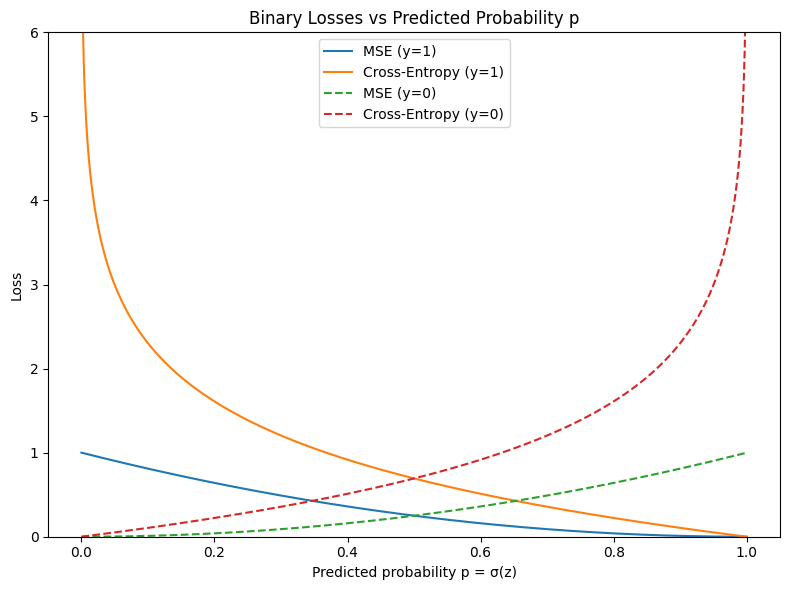

In [60]:
# ==================== PLOT 1: Loss vs predicted probability p ====================
p = np.linspace(1e-5, 1-1e-5, 1000)

plt.figure(figsize=(8, 6))
# y = 1
plt.plot(p, mse_loss(p, 1), label="MSE (y=1)")
plt.plot(p, bce_loss(p, 1), label="Cross-Entropy (y=1)")
#plt.plot(p, hinge_loss_from_p(p, 1), label="Hinge (y=1)")
#plt.plot(p, [focal_loss(pi, 1, gamma=2.0, alpha=0.25) for pi in p], label="Focal γ=2, α=0.25 (y=1)")
# y = 0
plt.plot(p, mse_loss(p, 0), label="MSE (y=0)", linestyle="--")
plt.plot(p, bce_loss(p, 0), label="Cross-Entropy (y=0)", linestyle="--")
#plt.plot(p, hinge_loss_from_p(p, 0), label="Hinge (y=0)", linestyle="--")
#plt.plot(p, [focal_loss(pi, 0, gamma=2.0, alpha=0.25) for pi in p], label="Focal γ=2, α=0.25 (y=0)", linestyle="--")

plt.title("Binary Losses vs Predicted Probability p")
plt.xlabel("Predicted probability p = σ(z)")
plt.ylabel("Loss")
plt.ylim(0, 6)
plt.legend()
plt.tight_layout()
plt.show()